In [2]:
import keras
import tensorflow as tf
import os,datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'keras'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.6 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
df = pd.read_csv("./r4.2/http.csv",nrows=100000)
df['date']=pd.to_datetime(df['date'])
df

,id,date,user,pc,url,content
0,{V1Y4-S2IR20QU-6154HFXJ},2010-01-02 06:55:16,LRR0148,PC-4275,http://msn.com/The_Human_Centipede_First_Seque...,remain representatives consensus concert altho...
1,{Q5R1-T3EF87UE-2395RWZS},2010-01-02 07:00:13,NGF0157,PC-6056,http://urbanspoon.com/Plunketts_Creek_Loyalsoc...,festival off northwards than congestion partne...
2,{X9O1-O0XW52VO-5806RPHG},2010-01-02 07:03:46,NGF0157,PC-6056,http://aa.com/Rhodocene/rhodocenium/fhaavatqrf...,long away reorganized baldwin seth business 18...
3,{G5S8-U5OG04TE-5299CCTU},2010-01-02 07:05:26,IRM0931,PC-7188,http://groupon.com/Leonhard_Euler/leonhard/tne...,among german schwein experimental becomes prev...
4,{L0R4-A9DH29VP-4553AUWM},2010-01-02 07:05:52,IRM0931,PC-7188,http://flickr.com/Inauguration_of_Barack_Obama...,kate criteria j 2008 highest 12 include books ...
...,...,...,...,...,...,...
99995,{F2B4-J5HG21CP-2472KNWD},2010-01-05 08:24:11,JIM0095,PC-9328,http://city-data.com/No_Way_Out_2004/hotty/sre...,enlarged under generic advantage vision do any...
99996,{P4C0-H4AC44QZ-5898ATQE},2010-01-05 08:24:12,BBS0039,PC-9436,http://stubhub.com/Hoover_Dam/ickes/zbgbeplpyr...,an unknown afternoon dietary state law nationa...
99997,{U9Y2-H0WW90NF-1184ROHW},2010-01-05 08:24:12,KAL0395,PC-0004,http://tigerdirect.com/European_Commission/bar...,begin top we band themselves harshly or fourth...
99998,{Y2Y4-T1KW57MX-2017DWRE},2010-01-05 08:24:12,LDB0090,PC-6824,http://microsoft.com/Meteorological_history_of...,until acquire flared get secondary minas sea u...


In [6]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(gpus)}")

Number of available GPUs: 2


In [14]:
# Download stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/iambee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iambee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/iambee/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Define the function to categorize time frames
def categorize_time_frame(hour):
    if 0 <= hour < 6:
        return 0
    elif 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    else:
        return 3

# Apply the function to create the 'time_frame' column
new_df = df.copy()
new_df['time_frame'] = df['date'].dt.hour.apply(categorize_time_frame)
new_df['day'] = df['date'].dt.day
new_df['month'] = df['date'].dt.month
new_df['year'] = df['date'].dt.year

new_df=new_df.drop(columns="date")

le_user = LabelEncoder()
le_user.fit(new_df['user'])
new_df['user'] = le_user.transform(new_df['user'])


#Save the user label encoder
pkl_user_output = open("user_encoder.pkl",'wb')
pickle.dump(le_user, pkl_user_output)


le_pc = LabelEncoder()
le_pc.fit(new_df['pc'])
new_df['pc'] = le_pc.transform(new_df['pc'])

#Save the PC label encoder
pkl_PC_output = open("pc_encoder.pkl",'wb')
pickle.dump(le_pc, pkl_PC_output)

In [12]:
# Step 1: Extract tokens from URLs for topic modeling
'''
URLs often contain words that reflect the purpose or content of the web page, such as "login," "profile," or "dashboard.
Split URLs into individual words or tokens to analyze their semantics.
For example, from the URL https://example.com/user/login, you could extract tokens like user and login.
'''
new_df['url'] = df['url'].str.replace("_",' ')
new_df['url_tokens'] = new_df['url'].str.extractall(r'(\w+)')[0].groupby(level=0).agg(' '.join)

texts = new_df['url_tokens'].tolist()  # Convert the column of texts into a list

In [15]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens

# Apply preprocessing to each row in the dataset
processed_texts = [preprocess_text(text) for text in texts]

In [20]:
# Create a dictionary and corpus from processed texts
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

In [27]:
# Function to compute coherence for different number of topics
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Define range of topics
start = 5
limit = 15
step = 2

# Compute coherence scores
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_texts, start=start, limit=limit, step=step)

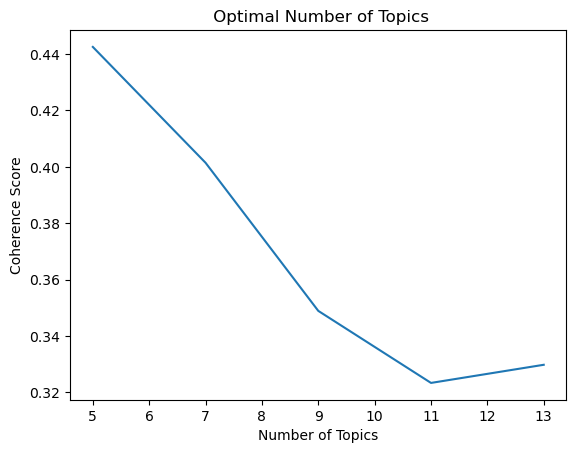

<Figure size 640x480 with 0 Axes>

In [29]:
# Plot the coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title(" Optimal Number of Topics")
plt.show()
plt.savefig('coherence_score_url_plot.png', format='png', dpi=300, bbox_inches='tight')

In [ ]:
# Print the optimal number of topics
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"The optimal number of topics is {optimal_num_topics}")

In [7]:
'''
When URLs are tokenized, they produce a high-dimensional representation (one dimension for each unique token).
LDA reduces this complexity by representing each URL as a mixture of topics.
'''

url_vectorizer = CountVectorizer()
url_matrix = url_vectorizer.fit_transform(new_df['url_tokens'])
url_matrix

<100000x8054 sparse matrix of type '<class 'numpy.int64'>'
	with 878550 stored elements in Compressed Sparse Row format>

In [6]:
n_topics_url = 10

lda = LDA(n_components=n_topics_url)
lda.fit(url_matrix)
url_topic_distribution = lda.transform(url_matrix)

for i in range(n_topics_url):
    new_df[f'url_topic_{i+1}'] = url_topic_distribution[:,i]

new_df=new_df.drop(columns="url")

KeyboardInterrupt: 

In [ ]:
# Step 1: Extract tokens from content for topic modeling
'''
URLs often contain words that reflect the purpose or content of the web page, such as "login," "profile," or "dashboard.
Split URLs into individual words or tokens to analyze their semantics.
For example, from the URL https://example.com/user/login, you could extract tokens like user and login.
'''

new_df['content_tokens'] = new_df['content'].str.extractall(r'(\w+)')[0].groupby(level=0).agg(' '.join)

In [ ]:
'''
When content's are tokenized, they produce a high-dimensional representation (one dimension for each unique token).
LDA reduces this complexity by representing each content as a mixture of topics.
'''

content_vectorizer = CountVectorizer()
content_matrix = content_vectorizer.fit_transform(new_df['content_tokens'])

In [ ]:
n_topics_content = 30

lda = LDA(n_components=n_topics_content)
lda.fit(content_matrix)
content_topic_distribution = lda.transform(content_matrix)

for i in range(n_topics_content):
    new_df[f'content_topic_topic_{i+1}'] = content_topic_distribution[:,i]

new_df=new_df.drop(columns="content")

In [187]:
new_df

,id,user,pc,time_frame,day,month,year,url_tokens,url_topic_1,url_topic_2,...,content_topic_topic_21,content_topic_topic_22,content_topic_topic_23,content_topic_topic_24,content_topic_topic_25,content_topic_topic_26,content_topic_topic_27,content_topic_topic_28,content_topic_topic_29,content_topic_topic_30
0,{V1Y4-S2IR20QU-6154HFXJ},620,423,1,2,1,2010,http msn com The Human Centipede First Sequenc...,0.008334,0.008334,...,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.978030,0.000758
1,{Q5R1-T3EF87UE-2395RWZS},707,586,1,2,1,2010,http urbanspoon com Plunketts Creek Loyalsock ...,0.009092,0.009092,...,0.001235,0.001235,0.001235,0.001235,0.001235,0.110480,0.001235,0.001235,0.001235,0.001235
2,{X9O1-O0XW52VO-5806RPHG},707,586,1,2,1,2010,http aa com Rhodocene rhodocenium fhaavatqrfxg...,0.012501,0.012501,...,0.001010,0.001010,0.001010,0.058153,0.001010,0.001010,0.191312,0.001010,0.001010,0.105751
3,{G5S8-U5OG04TE-5299CCTU},467,709,1,2,1,2010,http groupon com Leonhard Euler leonhard tneqr...,0.899987,0.011112,...,0.000794,0.000794,0.000794,0.000794,0.000794,0.000794,0.376662,0.000794,0.000794,0.000794
4,{L0R4-A9DH29VP-4553AUWM},467,709,1,2,1,2010,http flickr com Inauguration of Barack Obama b...,0.009093,0.009092,...,0.001075,0.001075,0.001075,0.001075,0.001075,0.001075,0.001075,0.001075,0.001075,0.001075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,{F2B4-J5HG21CP-2472KNWD},497,931,1,5,1,2010,http city data com No Way Out 2004 hotty sregv...,0.007693,0.007693,...,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680
99996,{P4C0-H4AC44QZ-5898ATQE},96,942,1,5,1,2010,http stubhub com Hoover Dam ickes zbgbeplpyrur...,0.899986,0.011113,...,0.000813,0.000813,0.000813,0.000813,0.000813,0.000813,0.000813,0.218937,0.000813,0.000813
99997,{U9Y2-H0WW90NF-1184ROHW},534,0,1,5,1,2010,http tigerdirect com European Commission barro...,0.011112,0.011113,...,0.000629,0.136306,0.000629,0.000629,0.000629,0.000629,0.000629,0.000629,0.133132,0.000629
99998,{Y2Y4-T1KW57MX-2017DWRE},595,681,1,5,1,2010,http microsoft com Meteorological history of H...,0.008336,0.008334,...,0.000741,0.000741,0.041566,0.124419,0.000741,0.000741,0.000741,0.000741,0.000741,0.000741
